In [ ]:
#@title Installing Required Packages
!pip install 'kaggle-environments>=0.1.6'

In [2]:
#@title Importing Packages
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from kaggle_environments import evaluate, make, utils
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D
from keras.layers import Flatten, Conv2D, Dense, MaxPooling2D, BatchNormalization, Dropout
from keras.optimizers import SGD
import pandas as pd

Loading environment lux_ai_s2 failed: No module named 'vec_noise'


In [3]:
#@title Defining Experience Class (for storing experience of each action)
class Experience:
  def __init__(self):
    self.clear()
  def clear(self):
    self.observations = []
    self.actions = []
    self.rewards = []
  def store(self, new_observation, new_act, new_reward):
    self.observations.append(new_observation)
    self.actions.append(new_act)
    self.rewards.append(new_reward) 

In [24]:
#@title Functions
def DQCNN(input_shape, h1, h2, h3, h4, h5, output_shape):
  model = Sequential()
  model.add(Conv2D(h1, (4, 4), activation = 'relu', input_shape = (6,7,1))) 
  model.add(Conv2D(h2, (2, 2), activation = 'relu')) 
  model.add(Flatten())
  model.add(Dense(h3, activation = 'relu'))
  model.add(Dense(h4, activation = 'relu'))
  model.add(Dense(h5, activation = 'relu'))
  model.add(Dense(output_shape, activation = 'linear'))
  return model

def DQN(input_shape, h1, h2, h3, h4, output_shape):
  model = Sequential()
  model.add(Flatten())
  model.add(Dense(h1, activation = 'relu'))
  model.add(Dense(h2, activation = 'relu'))
  model.add(Dense(h3, activation = 'relu'))
  model.add(Dense(h4, activation = 'relu'))
  model.add(Dense(output_shape, activation = 'linear'))
  return model

def ChooseAction(model, observation, epsilon, NUM_ACTIONS):
  predicts = model.predict(np.array([observation]))
  weights = tf.nn.softmax(predicts).numpy()[0]
  action = random.choices([np.argmax(weights), random.randint(0,6)], weights = [1 - epsilon, epsilon])[0] # epsilon greedy  
  valid_actions = set(range(NUM_ACTIONS))
  while True:
    temp_action = action
    if observation[0, action] != 0:
      valid_actions = valid_actions - set([action])
      action = random.choice(list(valid_actions))
    if temp_action == action:
      break
  return int(action)

def Reward(winner, done):
  if done: 
    if winner == 1: reward = 20
    else: reward = -100
  else:
    reward = -1
  return reward

def Training(model, optimizer, observations, actions, rewards):
  with tf.GradientTape() as tape: 
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = model(np.array(observations)), labels = np.array(actions)) + rewards)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))


def RandomVsRandom(BOARD_SIZE, NUM_ACTIONS, NUM_EPISODE):
  env = make("connectx", debug=True)
  Reward_list = np.zeros(NUM_EPISODE)
  win_num = 0; win_list = []
  for episode in range(NUM_EPISODE):
    trainer = env.train([None, 'random'])
    observation = np.array(trainer.reset()['board']).reshape(BOARD_SIZE) 
    done = False
    while True:
      Act = random.randint(0, NUM_ACTIONS-1)
      New_observation, winner, done, info = trainer.step(Act)
      observation = np.array(New_observation['board']).reshape(BOARD_SIZE)
      reward = Reward(winner, done)
      Reward_list[episode] += reward 
      if done: 
        if winner == 1: win_num += 1
        win_list.append(win_num)
        break
  return win_num, win_list, Reward_list

def DQN_Training(model, opt, EPSILONE_RATE, BOARD_SIZE, NUM_ACTIONS, NUM_EPISODE):
  env = make("connectx", debug=True)
  epsilon = 1; win_num = 0; win_list = []
  Reward_list = np.zeros(NUM_EPISODE)
  Exp = Experience()
  for episode in range(NUM_EPISODE):
    trainer = env.train([None, 'random'])
    observation = np.array(trainer.reset()['board']).reshape(BOARD_SIZE) 
    done = False
    while True:
      Act = ChooseAction(model, observation, epsilon, NUM_ACTIONS)
      New_observation, winner, done, info = trainer.step(Act)
      reward = Reward(winner, done)
      Reward_list[episode] += reward 
      Exp.store(observation, Act, reward)
      observation = np.array(New_observation['board']).reshape(BOARD_SIZE)
      if done: 
        if winner == 1: win_num += 1
        win_list.append(win_num)
        Training(model, opt, Exp.observations, Exp.actions, Exp.rewards)
        break
    Exp.clear()
    epsilon = np.exp(-episode * EPSILONE_RATE)
  return model, win_num, win_list, Reward_list, epsilon

def Test_DQN(model, epsilon, BOARD_SIZE, NUM_ACTIONS, NUM_EPISODE):
  env = make("connectx", debug=True)
  win_num = 0; win_list = []
  for episode in range(NUM_EPISODE):
    trainer = env.train([None, "random"])
    observation = np.array(trainer.reset()['board']).reshape(BOARD_SIZE) 
    done = False
    while True:
      Act = ChooseAction(model, observation, epsilon, NUM_ACTIONS)
      New_observation, winner, done, info = trainer.step(Act)
      env.render(mode = "ipython")
      observation = np.array(New_observation['board']).reshape(BOARD_SIZE)
      if done: 
        if winner == 1: win_num += 1
        win_list.append(win_num)
        break
  return win_num, win_list

In [23]:
#@title Defining the Hyperparameters
NUM_EPISODE = 1000
NUM_TEST = 1
EPSILONE_RATE = 0.05
BOARD_SIZE = [6,7]
NUM_ACTIONS = 7
window_size = 50

In [ ]:
#@title Random vs Random
win_num_RvR, win_list_RvR, Reward_list_RvR = RandomVsRandom(BOARD_SIZE, NUM_ACTIONS, NUM_EPISODE)
Reward_list_RvR_MC = pd.Series(Reward_list_RvR).rolling(window_size , min_periods = window_size).mean()

In [ ]:
#@title Training with Deep Q-Network
opt = tf.keras.optimizers.Adam()
model_DQN = DQN(BOARD_SIZE, 150, 150, 150, 150, NUM_ACTIONS)
model_DQN, win_num_DQN, win_list_DQN, Reward_list_DQN, eps = DQN_Training(model_DQN, opt, EPSILONE_RATE, BOARD_SIZE, NUM_ACTIONS, NUM_EPISODE)
Reward_list_DQN_MC = pd.Series(Reward_list_DQN).rolling(window_size , min_periods = window_size).mean()

In [53]:
#@title Testing the Trained Q-Network
win_num_Test_DQN, win_list_Test_DQN = Test_DQN(model_DQN, eps, BOARD_SIZE, NUM_ACTIONS, NUM_TEST)

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 21ms/step


In [ ]:
#@title Training with Deep Q-Network (CNN)
model_DQN_CNN = DQCNN(BOARD_SIZE, 64, 64, 64, 128, 64, NUM_ACTIONS)
model_DQN_CNN, win_num_DQN_CNN, win_list_DQN_CNN, Reward_list_DQN_CNN, eps = DQN_Training(model_DQN_CNN, opt, EPSILONE_RATE, BOARD_SIZE, NUM_ACTIONS, NUM_EPISODE)
Reward_list_DQN_CNN_MC = pd.Series(Reward_list_DQN_CNN).rolling(window_size , min_periods = window_size).mean()

In [36]:
#@title Testing the Trained Q-Network
win_num_Test_DQN_CNN, win_list_Test_DQN_CNN = Test_DQN(model_DQN_CNN, eps, BOARD_SIZE, NUM_ACTIONS, NUM_TEST)

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 34ms/step


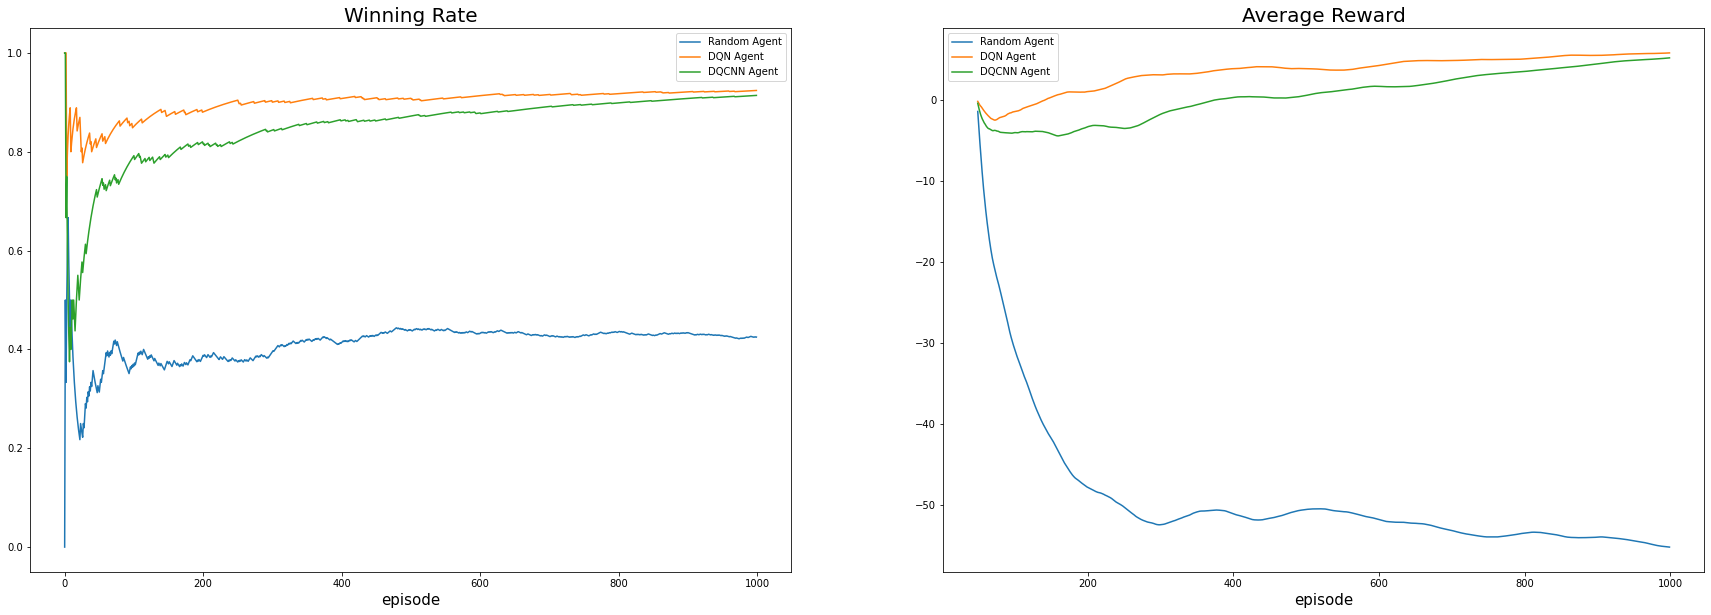

In [34]:
#@title Comparing Different Agents
plt.figure(figsize = (30,10))
plt.subplot(1,2,1)
plt.plot(win_list_RvR / (np.arange(NUM_EPISODE)+1), label = 'Random Agent')
plt.plot(win_list_DQN / (np.arange(NUM_EPISODE)+1), label = 'DQN Agent')
plt.plot(win_list_DQN_CNN / (np.arange(NUM_EPISODE)+1), label = 'DQCNN Agent')
plt.xlabel('episode', fontsize = 15)
plt.title('Winning Rate', fontsize = 20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(np.cumsum(Reward_list_RvR_MC) / (np.arange(NUM_EPISODE)+1),label = 'Random Agent')
plt.plot(np.cumsum(Reward_list_DQN_MC) / (np.arange(NUM_EPISODE)+1), label = 'DQN Agent')
plt.plot(np.cumsum(Reward_list_DQN_CNN_MC) / (np.arange(NUM_EPISODE)+1) , label = 'DQCNN Agent')
plt.xlabel('episode', fontsize = 15)
plt.title('Average Reward', fontsize = 20)
plt.legend()